# Dropout and Bit Errors
Prepared by Nicholas Belsten 4/30/2023
Last Updated 5/4/2023

## MNIST Data Set

Based on code from: https://nextjournal.com/gkoehler/pytorch-mnist

In [2]:
#Imports
import torch
import torchvision
from enum import Enum
import matplotlib.pyplot as plt

In [3]:
#Learning parameters
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
dropout_p = 0.5

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [5]:
# Build Network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=dropout_p, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [6]:
#Training the Model
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
num_correct = []

def train(mynetwork, epoch):
  mynetwork.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = mynetwork(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(mynetwork.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [7]:
#Test loop
def test(mynetwork):
  mynetwork.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = mynetwork(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  num_correct.append(correct)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [8]:
#Training loop
test(network)
for epoch in range(1, n_epochs + 1):
  train(network,epoch)
  test(network)

<ipython-input-5-055f8fcc5f87>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3316, Accuracy: 1137/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.360446
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.364010
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.329987
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.249067
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.288059
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.218085
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.214215
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.111192
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.092593
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.989863
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.911151
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.659503
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.869479
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.660094
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.577335
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.550470
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.304469
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.408615
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.306857
Train Epoch: 1 [12160

Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.296271
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.145353
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.380896
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.403530
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.452573
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.316833
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.270068
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.264257
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.289262
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.242738
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.421065
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.374339
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.241694
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.427617
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.375608
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.355623
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.244106
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.280670
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.301430
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.279837


Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.142049
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.118636
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.186219
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.205322
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.497077
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.165545
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.249922
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.209069
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.443884
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.406283
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.164242
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.125222
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.140726
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.250661
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.171653
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.290043
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.200770
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.220419
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.569561
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.116357


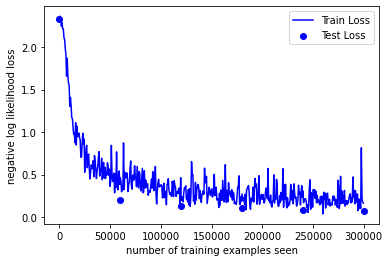

In [9]:
def plot_descent_results(res, color = 'blue', name = ""):
    plt.plot(res[0], res[1], color=color)
    plt.scatter(res[2], res[3], color=color)
    plt.legend([name + 'Train Loss', name + 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')


original_results = (train_counter, train_losses, test_counter, test_losses)
plot_descent_results(original_results)

### Mutate the Network

In [10]:
sum(p.numel() for p in network.parameters()) #Total number of parameters

21840

In [11]:
#Mutation functions
import struct
import copy
import torch
import random
import numpy as np

def bytearray_to_bits(bytearray_data):
    bits = []
    for byte in bytearray_data:
        for i in range(7, -1, -1):
            bits.append((byte >> i) & 1)
    return bits

def bits_to_bytearray(bits):
    bytearray_data = bytearray()
    for i in range(0, len(bits), 8):
        byte_bits = bits[i:i+8]
        byte = 0
        for j, bit in enumerate(byte_bits):
            byte |= bit << (7 - j)
        bytearray_data.append(byte)
    return bytearray_data

def mutate_bytearray(bytearray_data, significand_only = False):
    if significand_only:
        bit_idx = random.randint(0, (len(bytearray_data)-1)*8 - 1)
    else:
        bit_idx = random.randint(0, len(bytearray_data)*8 - 1)
    mybits = bytearray_to_bits(bytearray_data)
    mybits[bit_idx] = int(not bool(mybits[bit_idx]))
    return bits_to_bytearray(mybits)
    
def mutate_float(val):
    return struct.unpack("f",(mutate_bytearray(bytearray(struct.pack("f", val)))))[0]

def mutate_fp(val):
    return struct.unpack("f",(mutate_bytearray(bytearray(struct.pack("f", val)),True)))[0]

def mutate_int(val):
    return struct.unpack("i",(mutate_bytearray(bytearray(struct.pack("i", val)))))[0]
    
#Function that operates on a random bit
def mutate_native(val, fixedp=False):
    if fixedp:
        return mutate_fp(val)
    
    if isinstance(val, int):
        return mutate_int(val)
    elif isinstance(val, float):
        return mutate_float(val)
    else:
        raise ValueError
        

def tensor_mutation(weights, mutation_prob, fixedp=False):
    global NUMBER_MUTATIONS

    for idx in np.ndindex(weights.size()):
        if random.random() < mutation_prob:
            cur_weight = weights[idx].item()
            mutated_weight = mutate_native(cur_weight, fixedp)
            #print("One change: ",cur_weight, mutated_weight)

            
            with torch.no_grad():
                weights[idx] = mutated_weight
                NUMBER_MUTATIONS += 1
                
def network_mutation(net, prob, fixedp=True):
    for k, v in net.state_dict().items():
        tensor_mutation(v, prob,fixedp)


#### Evaluate the mutation distribution

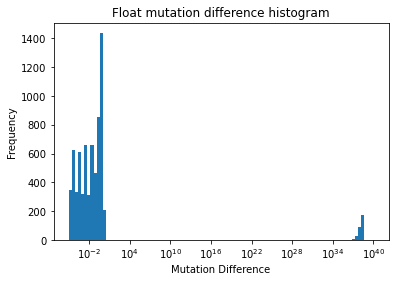

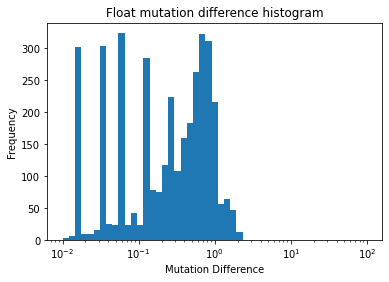

In [12]:
inputs = np.random.rand(10000)
outputs_float = np.array([mutate_float(val) for val in inputs])
errors_float = np.abs(inputs-outputs_float)

plt.hist(errors_float, bins=np.logspace(-5,40, 100))
plt.gca().set_xscale("log")
plt.title("Float mutation difference histogram")
plt.xlabel("Mutation Difference")
plt.ylabel("Frequency")
plt.show()

plt.hist(errors_float, bins=np.logspace(-2,2, 50))
plt.gca().set_xscale("log")
plt.title("Float mutation difference histogram")
plt.xlabel("Mutation Difference")
plt.ylabel("Frequency")
plt.show()

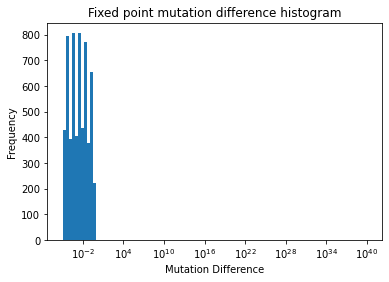

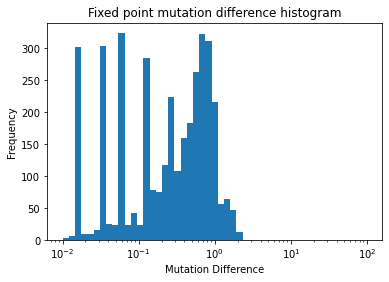

In [13]:
inputs = np.random.rand(10000)
outputs_fp = np.array([mutate_fp(val) for val in inputs])
errors_fp = np.abs(inputs-outputs_fp)

plt.hist(errors_fp, bins=np.logspace(-5,40, 100))
plt.gca().set_xscale("log")
plt.title("Fixed point mutation difference histogram")
plt.xlabel("Mutation Difference")
plt.ylabel("Frequency")
plt.show()

plt.hist(errors_float, bins=np.logspace(-2,2, 50))
plt.gca().set_xscale("log")
plt.title("Fixed point mutation difference histogram")
plt.xlabel("Mutation Difference")
plt.ylabel("Frequency")
plt.show()

#### Mutate the network (fixed point)

In [14]:
mutated_network = copy.deepcopy(network) # Copy the network

mutated_losses = []
mutated_accuracies = []

#Test loop
def one_test(this_network):
  this_network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = this_network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    
  return test_loss, correct.item()*100/ len(test_loader.dataset)


In [15]:
#For fixed precision
NUMBER_MUTATIONS = 0
mut_count = []
losses = []
accuracies = []
for p in np.logspace(-1,0,20):
    network_mutation(mutated_network,p,fixedp=True)
    loss, acc = one_test(mutated_network)
    losses.append(loss)
    accuracies.append(acc)
    mut_count.append(NUMBER_MUTATIONS)


<ipython-input-5-055f8fcc5f87>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.0756, Accuracy: 9765/10000 (98%)


Test set: Avg. loss: 0.0757, Accuracy: 9768/10000 (98%)


Test set: Avg. loss: 0.0750, Accuracy: 9772/10000 (98%)


Test set: Avg. loss: 0.0745, Accuracy: 9779/10000 (98%)


Test set: Avg. loss: 0.0766, Accuracy: 9769/10000 (98%)


Test set: Avg. loss: 0.0774, Accuracy: 9763/10000 (98%)


Test set: Avg. loss: 0.0781, Accuracy: 9755/10000 (98%)


Test set: Avg. loss: 0.0788, Accuracy: 9751/10000 (98%)


Test set: Avg. loss: 0.0847, Accuracy: 9739/10000 (97%)


Test set: Avg. loss: 0.0860, Accuracy: 9741/10000 (97%)


Test set: Avg. loss: 0.0928, Accuracy: 9709/10000 (97%)


Test set: Avg. loss: 0.0966, Accuracy: 9705/10000 (97%)


Test set: Avg. loss: 0.0942, Accuracy: 9710/10000 (97%)


Test set: Avg. loss: 0.0991, Accuracy: 9703/10000 (97%)


Test set: Avg. loss: 0.1017, Accuracy: 9701/10000 (97%)


Test set: Avg. loss: 0.1059, Accuracy: 9690/10000 (97%)


Test set: Avg. loss: 0.1022, Accuracy: 9694/10000 (97%)


Test set: Avg

Text(0.5, 1.0, 'Fixed Point Network Degradation')

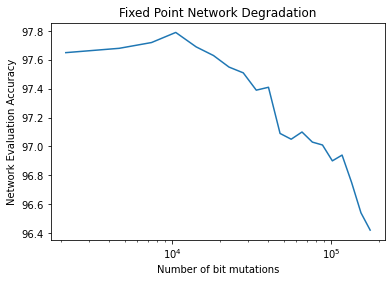

In [16]:
plt.semilogx(mut_count,accuracies)
plt.xlabel("Number of bit mutations")
plt.ylabel("Network Evaluation Accuracy")
plt.title("Fixed Point Network Degradation")

In [17]:
#For floating precision
float_mutated_network = copy.deepcopy(network) # Copy the network

float_mutated_losses = []
float_mutated_accuracies = []

NUMBER_MUTATIONS = 0
mut_count = []
losses = []
accuracies = []
for p in np.logspace(-5,-2,20):
    network_mutation(float_mutated_network,p,fixedp=False)
    loss, acc = one_test(float_mutated_network)
    losses.append(loss)
    accuracies.append(acc)
    mut_count.append(NUMBER_MUTATIONS)

<ipython-input-5-055f8fcc5f87>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.0761, Accuracy: 9764/10000 (98%)


Test set: Avg. loss: 0.0761, Accuracy: 9764/10000 (98%)


Test set: Avg. loss: 0.0761, Accuracy: 9764/10000 (98%)


Test set: Avg. loss: 0.0761, Accuracy: 9764/10000 (98%)


Test set: Avg. loss: 0.0761, Accuracy: 9764/10000 (98%)


Test set: Avg. loss: 0.0761, Accuracy: 9765/10000 (98%)


Test set: Avg. loss: 0.0761, Accuracy: 9765/10000 (98%)


Test set: Avg. loss: 0.0761, Accuracy: 9764/10000 (98%)


Test set: Avg. loss: 0.0761, Accuracy: 9764/10000 (98%)


Test set: Avg. loss: 0.0761, Accuracy: 9764/10000 (98%)


Test set: Avg. loss: 0.0768, Accuracy: 9762/10000 (98%)


Test set: Avg. loss: 0.0768, Accuracy: 9762/10000 (98%)


Test set: Avg. loss: 0.0764, Accuracy: 9761/10000 (98%)


Test set: Avg. loss: inf, Accuracy: 2031/10000 (20%)


Test set: Avg. loss: nan, Accuracy: 1058/10000 (11%)


Test set: Avg. loss: nan, Accuracy: 1059/10000 (11%)


Test set: Avg. loss: nan, Accuracy: 1057/10000 (11%)


Test set: Avg. loss: nan,

Text(0.5, 1.0, 'Floating Point Network Degradation')

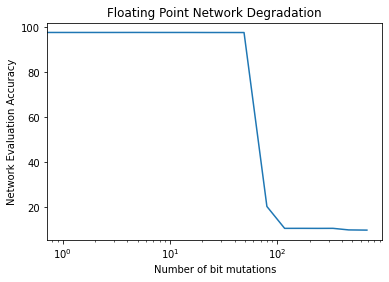

In [18]:
plt.semilogx(mut_count,accuracies)
plt.xlabel("Number of bit mutations")
plt.ylabel("Network Evaluation Accuracy")
plt.title("Floating Point Network Degradation")

## Run training without dropout

In [29]:
class ND_Net(nn.Module):
    def __init__(self):
        super(ND_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        #self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, p=dropout_p, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
ND_network = ND_Net()
optimizer = optim.SGD(ND_network.parameters(), lr=learning_rate,
                      momentum=momentum)

#Training the Model
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
num_correct = []

#Training loop
test(ND_network)
for epoch in range(1, n_epochs + 1):
  train(ND_network,epoch)
  test(ND_network)

<ipython-input-29-ab303eeae2e1>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3261, Accuracy: 754/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.328424
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.257800
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.232374
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.191454
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.032694
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.868352
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.637502
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.202043
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.982268
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.209353
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.776571
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.558388
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.792625
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.505590
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.546768
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.637985
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.411473
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.422665
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.657388
Train Epoch: 1 [12160/6

Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.019909
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.158873
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.157034
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.044749
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.025598
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.171161
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.031915
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.075315
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.092645
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.153908
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.028106
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.050204
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.140063
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.070002
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.062154
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.028249
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.079159
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.133497
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.062956
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.063903


Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.034028
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.027122
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.093244
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.060874
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.053785
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.087591
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.028140
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.020350
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.120634
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.077257
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.043506
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.013037
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.068680
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.113750
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.126312
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.090866
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.075112
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.009120
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.029903
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.201150


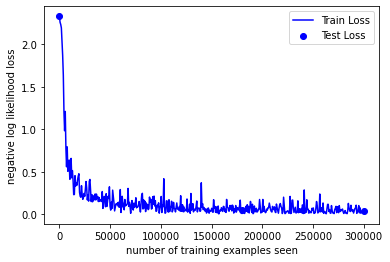

In [30]:
ND_results = (train_counter, train_losses, test_counter, test_losses)
plot_descent_results(ND_results)

### Training with Radiation Mutation instead

In [47]:
mut_p = 0.25
class RD_Net(nn.Module):
    def __init__(self):
        super(RD_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        #self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #tensor_mutation(x, mut_p, fixedp=True)
        #x = F.dropout(x, p=dropout_p, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
def rad_train(mynetwork, epoch):
  mynetwork.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = mynetwork(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      network_mutation(mynetwork, 0.25, fixedp=True)       #Here we apply mutation once per log interval
      torch.save(mynetwork.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')
    
    
RD_network = RD_Net()
optimizer = optim.SGD(RD_network.parameters(), lr=learning_rate,
                      momentum=momentum)

#Training the Model
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
num_correct = []

#Training loop
test(RD_network)
for epoch in range(1, n_epochs + 1):
  rad_train(RD_network,epoch)
  test(RD_network)

<ipython-input-47-cbee8887fa19>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3100, Accuracy: 1400/10000 (14%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321056
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.297462
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.238845
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.233055
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.114293
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.035550
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.953924
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.714317
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.419792
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.088077
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.217330
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.826938
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.823426
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.776403
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.864380
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.565359
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.606449
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.422018
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.446183
Train Epoch: 1 [12160

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.143129
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.074754
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.191405
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.028587
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.077417
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.036331
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.117334
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.235431
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.165405
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.031568
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.171255
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.100426
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.009183
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.141307
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.143053
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.040480
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.100908
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.130495
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.016537
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.221783


Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.094871
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.231494
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.089058
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.012186
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.161074
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.052150
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.132316
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.031131
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.122975
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.041307
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.078192
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.160922
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.108775
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.137286
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.057287
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.097247
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.042875
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.102694
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.051083
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.011560


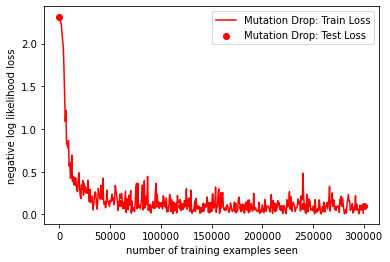

In [48]:
RD_results = (train_counter, train_losses, test_counter, test_losses)
plot_descent_results(RD_results, color = "red", name = "Mutation Drop: ")

### Final Plotting

Text(0, 0.5, 'negative log likelihood loss')

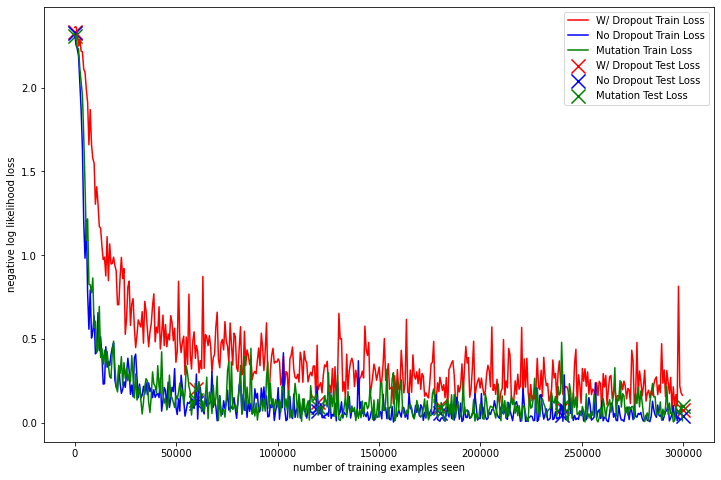

In [49]:
plt.figure(figsize=(12,8))
plt.plot(original_results[0], original_results[1], color="red", label = 'W/ Dropout Train Loss')
plt.scatter(original_results[2], original_results[3], color="red", label = 'W/ Dropout Test Loss', marker = "x", s=200)

plt.plot(ND_results[0], ND_results[1], color="blue", label = 'No Dropout Train Loss')
plt.scatter(ND_results[2], ND_results[3], color="blue", label = 'No Dropout Test Loss', marker = "x", s=200)

plt.plot(RD_results[0], RD_results[1], color="green", label = 'Mutation Train Loss')
plt.scatter(RD_results[2], RD_results[3], color="green", label = 'Mutation Test Loss', marker = "x", s=200)

plt.legend(loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')


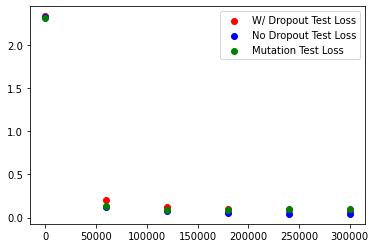

In [51]:
plt.scatter(original_results[2], original_results[3], color="red", label = 'W/ Dropout Test Loss')
plt.scatter(ND_results[2], ND_results[3], color="blue", label = 'No Dropout Test Loss')
plt.scatter(RD_results[2], RD_results[3], color="green", label = 'Mutation Test Loss')
plt.legend()